In [109]:
import json
import numpy as np
import pandas as pd
from keras.models import model_from_json
import matplotlib.pyplot as plt

import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import  confusion_matrix
import gym

label_col = 'Label'  # Define the label column name

In [110]:
class data_cls:
    def __init__(self, train_test, attack_map, **kwargs):
        self.train_test = train_test
        
        if self.train_test == 'train':
            self.train_path = "processed_data/train_df_subset.csv"
        else:
            self.test_path = "processed_data/train_df_subset.csv"

        self.attack_map =   attack_map 
        self.attack_types = list(attack_map.keys())
        
        self.loaded = False
    
    def get_batch(self, batch_size=100):
        if not self.loaded:
            self._load_df()
        
        # Ensure batch_size does not exceed the DataFrame size
        if batch_size > self.data_shape[0]:
            raise ValueError(f"batch_size ({batch_size}) cannot be larger than the dataset size ({self.data_shape[0]}).")
        
        # Calculate wrapped indices using modulo
        indexes = [(self.index + i) % self.data_shape[0] for i in range(batch_size)]
        
        # Update the index for the next batch
        self.index = (self.index + batch_size) % self.data_shape[0]
        
        # Select the batch using iloc with valid indices
        batch = self.df.iloc[indexes]
        
        map_type = pd.Series(index=self.attack_types, data=np.arange(len(self.attack_types))).to_dict()
        labels = batch[label_col].map(self.attack_map).map(map_type).values
        del batch[label_col]
        
        return np.array(batch), labels
    
    def get_full(self):

        self._load_df()
        
        batch = self.df
        map_type = pd.Series(index=self.attack_types,data=np.arange(len(self.attack_types))).to_dict()
        labels = batch[label_col].map(self.attack_map).map(map_type).values
        
        del(batch[label_col])
        
        return np.array(batch), labels
    
    def get_shape(self):
        if self.loaded is False:
            self._load_df()
        
        self.data_shape = self.df.shape
        return self.data_shape
    
    def _load_df(self):
        if self.train_test == 'train':
            self.df = pd.read_csv(self.train_path) 
        else:
            self.df = pd.read_csv(self.test_path)
            
        self.index=np.random.randint(0,self.df.shape[0]-1,dtype=np.int32)
        self.loaded = True

In [111]:
from gym import  spaces
import gym

class NetworkClassificationEnv(gym.Env, data_cls):
    def __init__(self,train_test, attack_map, **kwargs):
        data_cls.__init__(self,train_test, attack_map,**kwargs)
        self.data_shape = self.get_shape()
        self.batch_size = kwargs.get('batch_size', 1) 
        self.fails_episode = kwargs.get('fails_episode', 10) 
        
        # Gym spaces
        self.action_space = spaces.Discrete(len(self.attack_types))
        self.observation_space = spaces.Discrete(self.data_shape[0])
        
        self.observation_len = self.data_shape[1]-1
        
        self.counter = 0

    def _update_state(self):
        self.states,self.labels = self.get_batch(self.batch_size)
        

    def reset(self):
        self.states,self.labels = self.get_batch(self.batch_size)
        self.counter = 0
        
        return self.states
    
    def _get_rewards(self,actions):
        self.reward = 0
        if actions == self.labels:
            self.reward = 1
        else: 
            self.counter += 1

    def step(self,actions):
        self._get_rewards(actions)
            
        self._update_state()

        if self.counter >= self.fails_episode:
            self.done = True
        else:
            self.done = False
            
        return self.states, self.reward, self.done
    

In [112]:
import tensorflow as tf

def huber_loss(y_true, y_pred, clip_value=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < clip_value
    squared_loss = 0.5 * tf.square(error)
    linear_loss = clip_value * (tf.abs(error) - 0.5 * clip_value)
    return tf.where(is_small_error, squared_loss, linear_loss)


In [113]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [114]:
import torch
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, obs_size, num_actions, hidden_dense_layer_dict={"Dense_1": {"Size": 100}}, learning_rate=0.001):
        super(QNetwork, self).__init__()
        layers = []
        input_size = obs_size
        for key, value in hidden_dense_layer_dict.items():
            layers.append(nn.Linear(input_size, value["Size"]))
            layers.append(nn.ReLU())
            input_size = value["Size"]
        layers.append(nn.Linear(input_size, num_actions))
        self.model = nn.Sequential(*layers)
        self.learning_rate = learning_rate
    
    def forward(self, x):
        return self.model(x)

with open('label_dict.json') as json_file:
    label_dict = json.load(json_file)

label_dict

env = NetworkClassificationEnv('test', label_dict) 

# Initialize the model architecture
model = QNetwork(obs_size=env.observation_len,  # Make sure this matches your training
                num_actions=len(env.attack_types),
                hidden_dense_layer_dict={"Dense_2": {"Size": 64},
                                       "Dense_3": {"Size": 32}})

# Load the saved weights
model.load_state_dict(torch.load("models/DDQN_model.pth"))
model.eval()  # Set to evaluation mode




C:\Users\Logan\AppData\Local\Temp\ipykernel_5800\3001808460.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/DDQN_model.pth"))


RuntimeError: Error(s) in loading state_dict for QNetwork:
	size mismatch for model.0.weight: copying a param with shape torch.Size([64, 39]) from checkpoint, the shape in current model is torch.Size([64, 79]).

In [ ]:
# ...existing code...

# Replace the prediction section with PyTorch style inference:
total_reward = 0
    
true_labels = np.zeros(len(env.attack_types),dtype=int)
estimated_labels = np.zeros(len(env.attack_types),dtype=int)
estimated_correct_labels = np.zeros(len(env.attack_types),dtype=int)

states, labels = env.get_full()

# Convert states to PyTorch tensor and get predictions
with torch.no_grad():  # Disable gradient computation for inference
    states_tensor = torch.FloatTensor(states)
    q = model(states_tensor)  # Use model directly instead of predict
    q = q.numpy()  # Convert back to numpy for argmax

actions = np.argmax(q, axis=1)        


labs, true_labels = np.unique(labels, return_counts=True)

for indx,a in enumerate(actions):
    estimated_labels[a] +=1              
    if a == labels[indx]:
        total_reward += 1
        estimated_correct_labels[a] += 1


Accuracy = estimated_correct_labels / true_labels
Mismatch = estimated_labels - true_labels

print('\r\nTotal reward: {} | Number of samples: {} | Accuracy = {}%'.format(total_reward,
      len(states),float(100*total_reward/len(states))))
outputs_df = pd.DataFrame(index = env.attack_types,columns = ["Estimated","Correct","Total","Acuracy"])
for indx,att in enumerate(env.attack_types):
    outputs_df.iloc[indx].Estimated = estimated_labels[indx]
    outputs_df.iloc[indx].Correct = estimated_correct_labels[indx]
    outputs_df.iloc[indx].Total = true_labels[indx]
    outputs_df.iloc[indx].Acuracy = Accuracy[indx]*100
    outputs_df.iloc[indx].Mismatch = abs(Mismatch[indx])


Total reward: 23 | Number of samples: 400 | Accuracy = 5.75%


In [ ]:
outputs_df

,Estimated,Correct,Total,Acuracy
Benign,0,0,200,0.0
Botnet,0,0,20,0.0
Brute-force,353,20,20,100.0
DDoS attack,0,0,40,0.0
DoS attack,47,3,40,7.5
Infilteration,0,0,40,0.0
Web attack,0,0,40,0.0


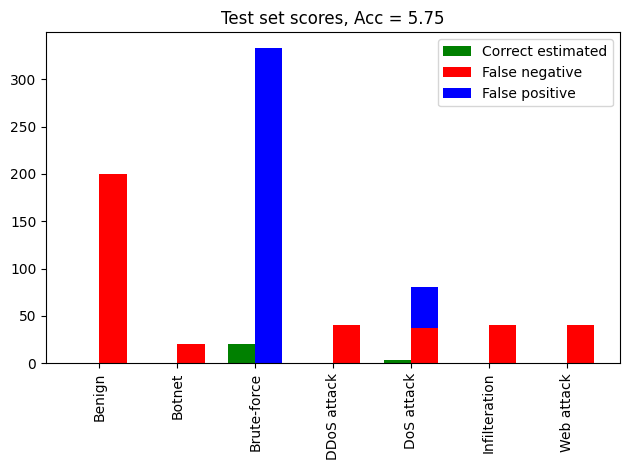

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()
width = 0.35
pos = np.arange(len(true_labels))
p1 = plt.bar(pos, estimated_correct_labels,width,color='g')
p1 = plt.bar(pos+width,
             (np.abs(estimated_correct_labels-true_labels)),width,
             color='r')
p2 = plt.bar(pos+width,np.abs(estimated_labels-estimated_correct_labels),width,
             bottom=(np.abs(estimated_correct_labels-true_labels)),
             color='b')


ax.set_xticks(pos+width/2)
ax.set_xticklabels(env.attack_types,rotation='vertical')

ax.set_title('Test set scores, Acc = {:.2f}'.format(100*total_reward/len(states)))
plt.legend(('Correct estimated','False negative','False positive'))
plt.tight_layout()
plt.show()
plt.savefig('results/ADFA_DDQN.svg', format='svg', dpi=1000)


Performance measures on Test data
Accuracy =  0.0575
F1 =  0.0123
Precision_score =  0.0092
recall_score =  0.0575
Normalized confusion matrix
[[0.   0.   0.81 0.   0.19 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.93 0.   0.07 0.   0.  ]
 [0.   0.   0.88 0.   0.12 0.   0.  ]
 [0.   0.   0.97 0.   0.03 0.   0.  ]]


b:\VSCode\Hierarchical-Q-Learning-Threat-Hunting\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

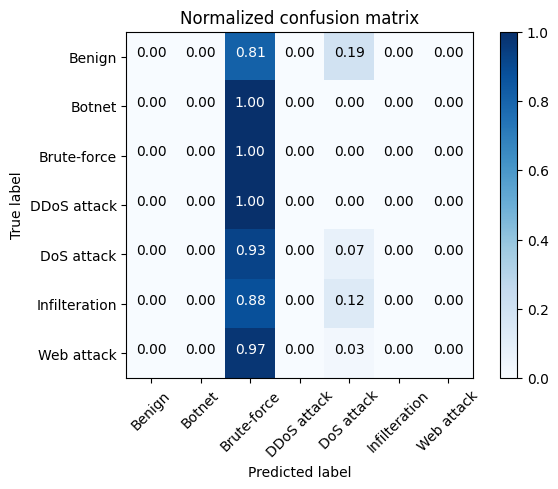

In [ ]:
aggregated_data_test =labels

print('Performance measures on Test data')
print('Accuracy =  {:.4f}'.format(accuracy_score( aggregated_data_test,actions)))
print('F1 =  {:.4f}'.format(f1_score(aggregated_data_test,actions, average='weighted')))
print('Precision_score =  {:.4f}'.format(precision_score(aggregated_data_test,actions, average='weighted')))
print('recall_score =  {:.4f}'.format(recall_score(aggregated_data_test,actions, average='weighted')))

cnf_matrix = confusion_matrix(aggregated_data_test,actions)
np.set_printoptions(precision=2)
plt.figure()
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=env.attack_types, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('results/confusion_matrix_DDQN_model.svg', format='svg', dpi=1000)

In [ ]:
import pandas as pd
train_df = pd.read_csv("processed_data/train_df.csv")
test_df = pd.read_csv("processed_data/test_df.csv")

with open('processed_data/class_weights.json', 'r') as f:
    class_weights = json.load(f)
with open('processed_data/label_dict.json', 'r') as f:
    label_dict = json.load(f)